In [171]:
data_frame = pd.read_csv("Multiple Connections_olist_orders_dataset.csv")
customer_zip_code = data_frame['Customer Zip Code Prefix']
seller_zip_code = data_frame['Seller Zip Code Prefix']
customer_country_code = []
seller_country_code = []

In [172]:
import numpy as np 
import pandas as pd
import os
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.driver.maxResultSize", "100g").config("spark.driver.memory", '100g').appName('SparkByExamples.com').getOrCreate()

data_sellers = spark.read.csv("olist_sellers_dataset.csv", header='True')

# Reading the costumers dataset
data_custumers = spark.read.csv("olist_customers_dataset.csv",header='True')  #99441

# Reading the orders datasets
data_orders = spark.read.csv("olist_orders_dataset.csv", header='True')
data_order_items = spark.read.csv("olist_order_items_dataset.csv",header='True')
data_order_payments = spark.read.csv("olist_order_payments_dataset.csv",header='True')
data_order_reviews = spark.read.csv("olist_order_reviews_dataset.csv",header='True')

# Reading the products dataset
data_products = spark.read.csv("olist_products_dataset.csv",header='True')

# Reading the geolocation dataset
data_geolocation = spark.read.csv("olist_geolocation_dataset.csv",header='True')

# Reading the category name translator
data_translator = spark.read.csv("product_category_name_translation.csv",header='True')


In [173]:
data_geo = pd.read_csv("olist_geolocation_dataset.csv")
data_geo = data_geo.sort_values('geolocation_zip_code_prefix')
single_zip = data_geo.drop_duplicates(subset ="geolocation_zip_code_prefix")
sp_zip_code = spark.createDataFrame(single_zip)

In [174]:
data_orders_customer = data_orders.join(data_custumers,data_orders.customer_id == data_custumers.customer_id)
data = data_orders_customer.join(data_order_items,data_orders_customer.order_id == data_order_items.order_id)
data = data.join(sp_zip_code,data.customer_zip_code_prefix == sp_zip_code.geolocation_zip_code_prefix)
data = data.withColumnRenamed('geolocation_zip_code_prefix','customer_geolocation_zip_code_prefix')
data = data.withColumnRenamed('geolocation_lat','customer_geolocation_lat')
data = data.withColumnRenamed('geolocation_lng','customer_geolocation_lng') 
data = data.withColumnRenamed('geolocation_city','customer_geolocation_city') 
data = data.withColumnRenamed('geolocation_state','customer_geolocation_state')
data = data.join(data_products,data.product_id == data_products.product_id)
data = data.join(data_sellers,data.seller_id == data_sellers.seller_id)
data = data.join(data_translator,data.product_category_name == data_translator.product_category_name)
data = data.join(sp_zip_code,data.seller_zip_code_prefix == sp_zip_code.geolocation_zip_code_prefix)
data = data.withColumnRenamed('geolocation_zip_code_prefix','seller_geolocation_zip_code_prefix')
data = data.withColumnRenamed('geolocation_lat','seller_geolocation_lat')
data = data.withColumnRenamed('geolocation_lng','seller_geolocation_lng') 
data = data.withColumnRenamed('geolocation_city','seller_geolocation_city') 
data = data.withColumnRenamed('geolocation_state','seller_geolocation_state')


In [175]:
data = data.drop('order_id').drop('customer_id').drop('seller_id').drop('product_id').drop('product_category_name')

In [176]:
data.printSchema()

root
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: string (nullable = true)
 |-- order_estimated_delivery_date: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- order_item_id: string (nullable = true)
 |-- shipping_limit_date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- freight_value: string (nullable = true)
 |-- customer_geolocation_zip_code_prefix: long (nullable = true)
 |-- customer_geolocation_lat: double (nullable = true)
 |-- customer_geolocation_lng: double (nullable = true)
 |-- customer_geolocation_city: string (nullable = true)
 |-- customer_geolocation_state: string (nullable = tr

In [126]:
#data.write.csv('merged_data_with_zip')
#pd_data = data.toPandas()#.to_csv('merged_data_pyspark_with_zip.csv')

In [178]:
data.show()

+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+------------------------+--------------+--------------+-------------+-------------------+------+-------------+------------------------------------+------------------------+------------------------+-------------------------+--------------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+----------------------+--------------------+------------+-----------------------------+----------------------------------+----------------------+----------------------+-----------------------+------------------------+
|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|  customer_unique_id|customer_zip_code_prefix| customer_city|customer_state|ord

In [179]:
from haversine import haversine, Unit

seller_loc   = np.array(list(zip(pd_data['seller_geolocation_lat'],pd_data['seller_geolocation_lng'])))
customer_loc = np.array(list(zip(pd_data['customer_geolocation_lat'],pd_data['customer_geolocation_lng'])))
distance = []
for i in range(0,len(seller_loc)):
        d = haversine(seller_loc[i], customer_loc[i], unit=Unit.MILES)
        distance.append(d)

In [180]:
pd_data = pd.read_csv('merged_data_pyspark_zip_distance.csv')
pd_data

,Unnamed: 0,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,...,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,seller_geolocation_zip_code_prefix,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state,Distance in Miles
0,0,delivered,2017-02-07 13:59:49,2017-02-09 02:50:11,2017-02-10 14:17:49,2017-03-01 09:03:41,2017-03-08 00:00:00,17d985e9775f2e84a22e7725e8d07234,90670,porto alegre,...,2040,sao paulo,SP,pet_shop,2040,-23.491384,-46.623687,sao paulo,SP,533.376427
1,1,delivered,2017-03-19 08:28:10,2017-03-19 08:28:10,2017-03-21 09:52:22,2017-03-27 15:24:49,2017-04-10 00:00:00,0a03a3d54e8a0debf7e00c3a7bb7ddc3,22220,rio de janeiro,...,2040,sao paulo,SP,pet_shop,2040,-23.491384,-46.623687,sao paulo,SP,222.352368
2,2,delivered,2017-03-20 20:31:35,2017-03-20 20:31:35,2017-03-24 15:18:33,2017-04-13 17:42:26,2017-04-12 00:00:00,05b3b3ee23ee41022bac0887570c9064,95088,caxias do sul,...,2040,sao paulo,SP,cool_stuff,2040,-23.491384,-46.623687,sao paulo,SP,483.405453
3,3,delivered,2017-02-28 17:28:52,2017-02-28 19:20:26,2017-03-01 14:50:48,2017-03-06 17:28:17,2017-03-22 00:00:00,e09b74bdbfb36ed596e4fcd32a35e1ed,35500,divinopolis,...,2040,sao paulo,SP,pet_shop,2040,-23.491384,-46.623687,sao paulo,SP,257.639832
4,4,delivered,2017-02-28 17:28:52,2017-02-28 19:20:26,2017-03-01 14:50:48,2017-03-06 17:28:17,2017-03-22 00:00:00,e09b74bdbfb36ed596e4fcd32a35e1ed,35500,divinopolis,...,2040,sao paulo,SP,pet_shop,2040,-23.491384,-46.623687,sao paulo,SP,257.639832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110471,110471,delivered,2017-04-21 11:08:41,2017-04-25 08:23:04,2017-04-25 10:56:25,2017-05-04 15:45:44,2017-05-23 00:00:00,da1b97ca23276d63c99d68596254e120,32265,contagem,...,95690,rolante,RS,consoles_games,95690,-29.641822,-50.549223,rolante,RS,783.609540
110472,110472,delivered,2017-03-13 00:26:12,2017-03-13 00:26:12,2017-03-13 10:20:59,2017-03-20 13:44:58,2017-04-07 00:00:00,412f80b814dba8dd3aa39c6be5bb29c8,22280,rio de janeiro,...,95690,rolante,RS,consoles_games,95690,-29.641822,-50.549223,rolante,RS,649.049599
110473,110473,delivered,2017-03-09 23:56:22,2017-03-09 23:56:22,2017-03-10 10:23:56,2017-03-14 12:53:56,2017-03-29 00:00:00,0ac04692cb471b1db3d5a60959aacd50,90010,porto alegre,...,95690,rolante,RS,consoles_games,95690,-29.641822,-50.549223,rolante,RS,49.228014
110474,110474,delivered,2017-05-31 21:12:24,2017-05-31 21:30:17,2017-06-01 10:49:23,2017-06-22 17:25:51,2017-06-27 00:00:00,dc5c27a2fadcf512851a328cc0d2594b,13181,sumare,...,95690,rolante,RS,consoles_games,95690,-29.641822,-50.549223,rolante,RS,513.806724


In [181]:
order_purchase_time = pd.to_datetime(pd_data['order_purchase_timestamp'])
order_approved_time = pd.to_datetime(pd_data['order_approved_at'])
order_delivered_carrier_time = pd.to_datetime(pd_data['order_delivered_carrier_date'])

order_estimated_delivery_date = pd.to_datetime(pd_data['order_estimated_delivery_date'])
order_delivered_customer_date = pd.to_datetime(pd_data['order_delivered_customer_date'])

In [182]:
diff_estimate_V_purchase = order_estimated_delivery_date - order_purchase_time
diff_estimate_V_approved = order_estimated_delivery_date - order_approved_time
diff_estimate_V_carrier = order_estimated_delivery_date - order_delivered_carrier_time

diff_delivery_V_purchase = order_delivered_customer_date - order_purchase_time
diff_delivery_V_approved = order_delivered_customer_date - order_approved_time
diff_delivery_V_carrie = order_delivered_customer_date - order_delivered_carrier_time

diff_estimate_V_delivery = order_estimated_delivery_date - order_delivered_customer_date

In [183]:
for i in range(0,len(diff_estimate_V_delivery)):
    diff_estimate_V_purchase[i] = diff_estimate_V_purchase[i].days
    diff_estimate_V_approved[i] = diff_estimate_V_approved[i].days
    diff_estimate_V_carrier[i]  = diff_estimate_V_carrier[i].days
    diff_delivery_V_purchase[i] = diff_delivery_V_purchase[i].days
    diff_delivery_V_approved[i] = diff_delivery_V_approved[i].days
    diff_delivery_V_carrie[i]   = diff_delivery_V_carrie[i].days
    diff_estimate_V_delivery[i] = diff_estimate_V_delivery[i].days

In [133]:
#a = np.array(diff_estimate_V_delivery)
a = np.array(pd.to_numeric(diff_estimate_V_delivery))
np.nanmean(a)

11.045288464206758

In [184]:
pd_data['Estimate and Purchase Date diff'] = pd.to_numeric(diff_estimate_V_purchase)
pd_data['Estimate and Approved diff'] = pd.to_numeric(diff_estimate_V_approved)
pd_data['Estimate and Carrier diff'] = pd.to_numeric(diff_estimate_V_carrier)
pd_data['Delivery and Purchase diff'] = pd.to_numeric(diff_delivery_V_purchase)
pd_data['Delivery and Approved diff'] = pd.to_numeric(diff_delivery_V_approved)
pd_data['Delivery and Carrier diff'] = pd.to_numeric(diff_delivery_V_carrie)
pd_data['Estimate and delivery diff'] = pd.to_numeric(diff_estimate_V_delivery)

In [187]:
pd_data.to_csv('merged_data_pyspark_zip_distance_cal_days.cvs')

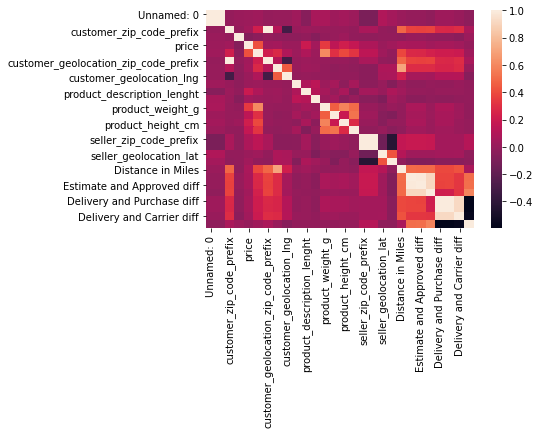

In [4]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

val = pd.read_csv('merged_data_pyspark_zip_distance_cal_days.cvs')
hm = sn.heatmap(data = val.corr())
  
# displaying the plotted heatmap
plt.show()